# 鐵達尼生存預測（精簡版）
https://www.kaggle.com/c/titanic

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression

## 讀取csv

In [2]:
df_train = pd.read_csv('./data/' + 'titanic_train.csv')
df_test = pd.read_csv('./data/' + 'titanic_test.csv')

## 快速查看資料
- PassengerId: 乘客編號
- Survived: 乘客是否存活（1代表存活，0代表死亡）
- Pclass: 艙位是頭等艙、二等艙還是三等艙
- Name: 乘客姓名
- Sex: 乘客的性別
- Age: 乘客的年齡
- SibSp: 在鐵達尼號上兄弟姐妹或者配偶的人數
- Parch: 在鐵達尼號上父母或者子女的人數
- Ticket: 乘客的船票號碼
- Fare: 買的船票價格
- Cabin: 在船上住的房間編號
- Embarked: 在英國哪個港口上的船

In [3]:
print(df_train.shape)
df_train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(df_test.shape)
df_test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 快速畫圖目標值與特徵

### 生存的比例大概是4成、死亡的比例是6成

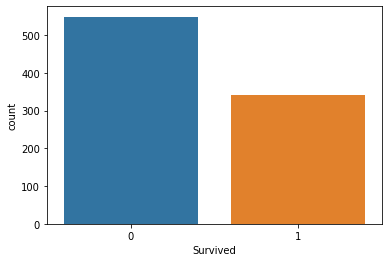

In [5]:
sns.countplot(df_train['Survived'])

### 女人生存率是男人的好幾倍

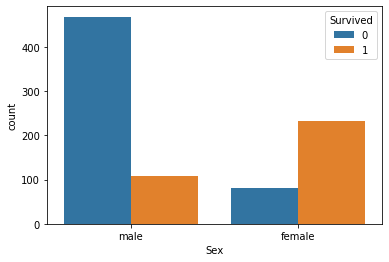

In [6]:
sns.countplot(df_train['Sex'], hue=df_train['Survived'])

### 1等艙的生存率最高、再來是2等艙、最後是3等艙

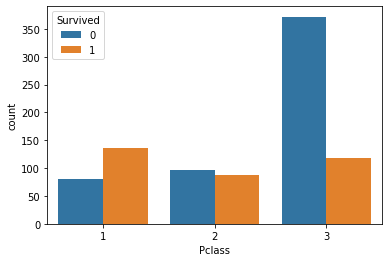

In [7]:
sns.countplot(df_train['Pclass'], hue=df_train['Survived'])

### S港出發的都比較容易死亡

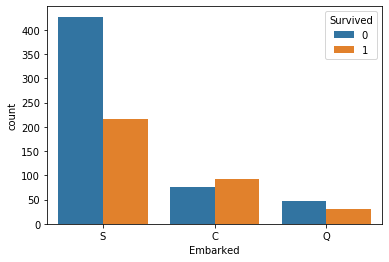

In [8]:
sns.countplot(df_train['Embarked'], hue=df_train['Survived'])

### 年齡小的存活比例高

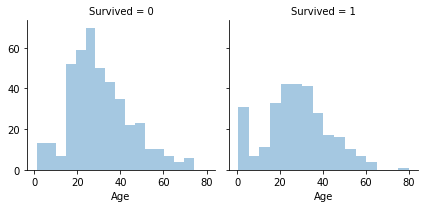

In [9]:
g = sns.FacetGrid(df_train, col='Survived')
g.map(sns.distplot, 'Age', kde=False)

### 沒有跟家人一起上船的，生存率偏低

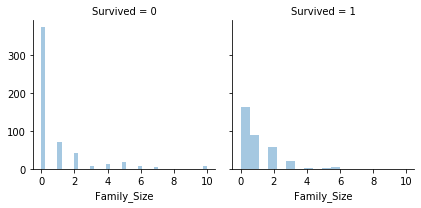

In [10]:
# 把「父母＋小孩」加上「兄弟姊妹＋丈夫妻子」的數量變成一個新的欄位叫做家庭大小
df_train['Family_Size'] = df_train['Parch'] + df_train['SibSp']

g = sns.FacetGrid(df_train, col='Survived')
g.map(sns.distplot, 'Family_Size', kde=False)

## 取出目標欄位

In [11]:
Y_train = df_train['Survived']

df_train = df_train.drop(['Survived'] , axis=1) # 移除欄位

## 取出非特徵欄位

In [12]:
ids = df_test['PassengerId']

df_train = df_train.drop(['PassengerId'] , axis=1) # 移除欄位
df_test = df_test.drop(['PassengerId'] , axis=1) # 移除欄位

## 合併df_train、df_test

In [13]:
df = pd.concat([df_train,df_test])
df.head()

/Users/ianfan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,Age,Cabin,Embarked,Family_Size,Fare,Name,Parch,Pclass,Sex,SibSp,Ticket
0,22.0,NaN,S,1.0,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,A/5 21171
1,38.0,C85,C,1.0,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,PC 17599
2,26.0,NaN,S,0.0,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,STON/O2. 3101282
3,35.0,C123,S,1.0,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,113803
4,35.0,NaN,S,0.0,8.0500,"Allen, Mr. William Henry",0,3,male,0,373450


## 填補缺失值
## 編碼
## 歸一化

In [14]:
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        print(c)
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

Cabin
Embarked
Name
Sex
Ticket


,Age,Cabin,Embarked,Family_Size,Fare,Name,Parch,Pclass,Sex,SibSp,Ticket
0,0.283951,0.000000,1.000000,0.181818,0.016072,0.118683,0.0,1.0,1.0,0.125,0.775862
1,0.481481,0.575269,0.333333,0.181818,0.140813,0.218989,0.0,0.0,0.0,0.125,0.879310
2,0.333333,0.000000,1.000000,0.090909,0.017387,0.400459,0.0,1.0,0.0,0.000,0.984914
3,0.444444,0.381720,1.000000,0.181818,0.105390,0.323124,0.0,0.0,0.0,0.125,0.070043
4,0.444444,0.000000,1.000000,0.090909,0.017630,0.016845,0.0,1.0,1.0,0.000,0.699353


## 取得X_train、y_train

In [15]:
train_num = Y_train.shape[0]
X_train = df[:train_num]
X_test = df[train_num:]

## 訓練模型

In [16]:
model = LogisticRegression()
model.fit(X_train, Y_train)

/Users/ianfan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

## 預測X_test

In [17]:
pred = model.predict(X_test)
sub = pd.DataFrame({'PassengerId': ids, 'Survived': pred})

## 儲存預測數據

In [18]:
sub.to_csv('titanic_baseline.csv', index=False) 